Setup

In [32]:
import os
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [33]:
# approach = 'Baseline'
approach = 'SBERT based'

# result_file = '00_data/keyword_search_results/pdfminer_found_sentences.json'
result_file = '00_data/encoding_based_similarity_analysis_results/pdfminer_found_sentences_th=0.65_sample=1.json'
validation_file = '00_data/validation_data/pdfminer_matched_sentences.json'

with open(result_file, encoding="utf-8") as f:
    results = json.load(f)

with open(validation_file, encoding="utf-8") as f:
    validation = json.load(f)


Match Paragraphs

In [34]:
rel_par = {}
for company, value in validation.items():
    rel_par[company] = {}

    for topic, sentences in value.items():
        rel_par[company][topic] = []

        for sentence in sentences:
            if sentence[0] not in rel_par[company][topic]:
                rel_par[company][topic].append(sentence[0])

found_par = {}
for company, value in results.items():
    found_par[company] = {}

    for topic, sentences in value.items():
        found_par[company][topic] = []

        for sentence in sentences:
            if sentence[0] not in found_par[company][topic]:
                found_par[company][topic].append(sentence[0])

Create results table

In [35]:
overlap_results = []

for company, value in rel_par.items():
    for topic, par_v in value.items():

        par_r = found_par[company][topic]
        res_row = [company, topic, len(par_v), len(par_r)]
        overlap = [value for value in par_r if value in par_v]

        res_row.append(len(overlap))
        overlap_results.append(res_row)

df_overlap = pd.DataFrame(overlap_results, columns=['Company', 'Topic', 'Validation paragraphs', 'Found paragraphs', 'Overlap'])

In [36]:
excerpt = []

for company, value in rel_par.items():
    
    for topic, par_v in value.items():
        

        val_only = []
        class_only = []
        overlap = []

        par_r = found_par[company][topic]

        for par in par_v:
            if par in par_r:
                overlap.append(par)
            else:
                val_only.append(par)

        for par in par_r:
            if par not in par_v:
                class_only.append(par)

        for par in val_only:
            res_row = [company, topic, 1, 0, par]
            excerpt.append(res_row)

        for par in class_only:
            res_row = [company, topic, 0, 1, par]
            excerpt.append(res_row)

        for par in overlap:
            res_row = [company, topic, 1, 1, par]
            excerpt.append(res_row)


df_excerpt = pd.DataFrame(excerpt, columns=['Company', 'Topic', 'in_val', 'in_detected', 'id'])

PARSED_DIRECTORY = '00_data/parsing_results'
parsing_method = 'pdfminer'
PARSING_RESULTS = (file for file in os.listdir(PARSED_DIRECTORY) if (os.path.isfile(os.path.join(PARSED_DIRECTORY, file)) and file.endswith(".json")))
PARSING_RESULTS = [file for file in PARSING_RESULTS if parsing_method in file]

pars = {}
for file in PARSING_RESULTS:
    parsing_method = file.split('_')[0]
    company = file.split('_')[1]
    with open('{}/{}'.format(PARSED_DIRECTORY, file)) as f:
        parsed_text = json.load(f)
        if parsing_method not in pars:
            pars[parsing_method] = {}
        pars[parsing_method][company] = parsed_text



blocks = []

for id, row in df_excerpt.iterrows():
    par = pars[parsing_method][row['Company']][row['id']].items()
    all_text = ''
    for key, value in par:
        all_text += '' + (value)
    blocks.append(all_text)


df_excerpt['block'] = blocks
df_excerpt.to_csv('00_data/evaluation_results/{}.csv'.format(approach), sep=';', encoding='utf-8-sig', index=False)
        

Visualize results table

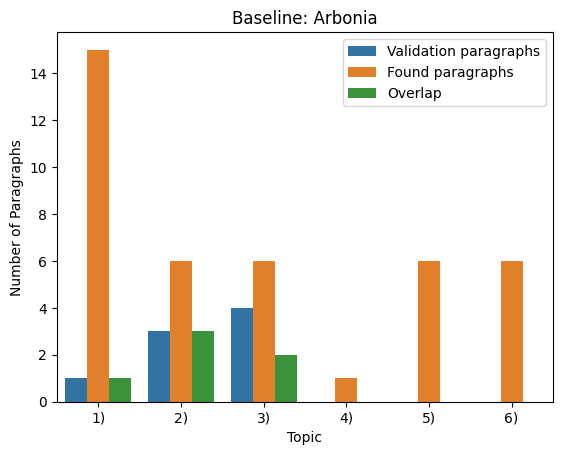

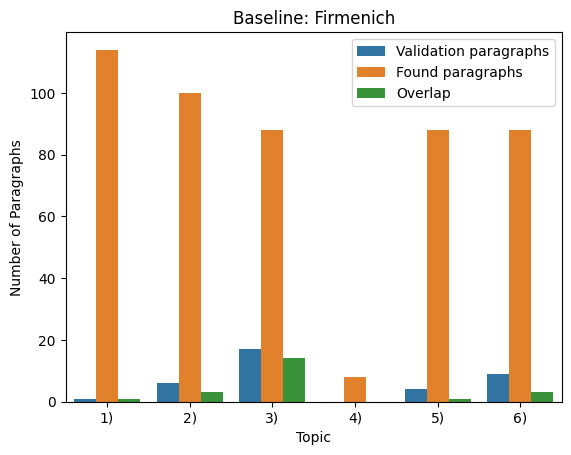

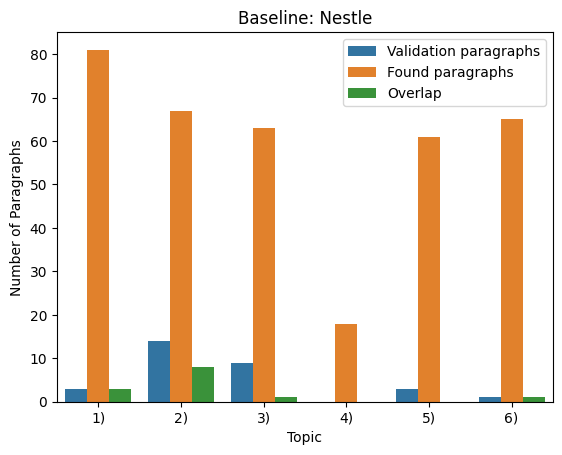

In [37]:
df_vis = df_overlap.copy()

df_vis['Topic'] = df_vis['Topic'].str.slice(0,2)
df_vis = pd.melt(df_vis, id_vars=['Company', 'Topic'], value_vars=['Validation paragraphs', 'Found paragraphs', 'Overlap'])

df_vis.columns = ['Company', 'Topic', 'group', 'Number of Paragraphs']

for company in df_vis['Company'].unique():
    df_tmp = df_vis[df_vis['Company'] == company]
    fig = sns.barplot(data=df_tmp, x='Topic', y='Number of Paragraphs', hue='group')
    fig.set(title=approach + ': ' + company)
    fig.legend_.set_title(None)
    plt.show()
